In [29]:
import pandas as pd
import glob
import os
import regex as re
import string
import time
import seaborn as sns
import datetime
import spacy
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.express as px
from spacy.lang.id import Indonesian
from spacy.lang.id.stop_words import STOP_WORDS
import warnings; warnings.simplefilter('ignore')

In [2]:
df = pd.read_csv("..\Data\Data Label\comments_2000_label.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Video_Id     2000 non-null   object 
 1   Tittle       2000 non-null   object 
 2   Name         2000 non-null   object 
 3   Comment      2000 non-null   object 
 4   Comment_Id   2000 non-null   object 
 5   Time         2000 non-null   object 
 6   Likes        2000 non-null   int64  
 7   Reply_Count  1658 non-null   float64
 8   Label        2000 non-null   object 
dtypes: float64(1), int64(1), object(7)
memory usage: 140.8+ KB


In [3]:
df["Label"] = df["Label"].astype("category")
df["Time"] = df["Time"].astype("datetime64")

In [4]:
df.head()

,Video_Id,Tittle,Name,Comment,Comment_Id,Time,Likes,Reply_Count,Label
0,0iLgiRBQzzs,Panas! Jokowi VS Prabowo Saling Serang soal Ko...,Suliani Suliani,"Astaqfirulloh haladzim,,,,prabowo ngomongnya g...",UgyZDJRwfuqy0M1CrKd4AaABAg,2019-01-21 05:51:44,0,0.0,legitimate
1,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,Fantasy GT,Uh She Up '-',UgwifLELkBIGe9o77tZ4AaABAg,2019-04-17 22:36:07,0,0.0,legitimate
2,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,melanie mutia,@BTS ARMY FOREVER ya suka suka gw ngmg bacot k...,Ugw_tmXCy-ZlbwpvzYJ4AaABAg.8voVbBid09j8yUdsPWIbWd,2019-08-11 08:58:04,0,NaN,legitimate
3,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,Dio Pangestu ARK,channel anda yang BOOM,Ugx9pam3Je2DOCwcMYx4AaABAg,2020-08-17 09:12:18,1,0.0,legitimate
4,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,AJENG 9955,ko dandan muslim,Ugzy7SLIQTfPjRdKQXN4AaABAg,2019-04-10 06:09:45,0,0.0,legitimate


In [5]:
df.isnull().sum()

Video_Id         0
Tittle           0
Name             0
Comment          0
Comment_Id       0
Time             0
Likes            0
Reply_Count    342
Label            0
dtype: int64

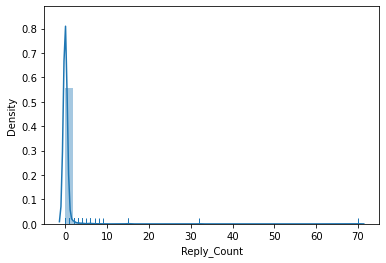

In [6]:
p = sns.distplot(df['Reply_Count'], kde=True, rug=True)

In [7]:
df['Reply_Count'].fillna(df['Reply_Count'].median(),inplace=True)

In [8]:
df.isnull().sum()

Video_Id       0
Tittle         0
Name           0
Comment        0
Comment_Id     0
Time           0
Likes          0
Reply_Count    0
Label          0
dtype: int64

In [9]:
df["Reply_Count"] = df["Reply_Count"].astype("int64")

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Video_Id     2000 non-null   object        
 1   Tittle       2000 non-null   object        
 2   Name         2000 non-null   object        
 3   Comment      2000 non-null   object        
 4   Comment_Id   2000 non-null   object        
 5   Time         2000 non-null   datetime64[ns]
 6   Likes        2000 non-null   int64         
 7   Reply_Count  2000 non-null   int64         
 8   Label        2000 non-null   category      
dtypes: category(1), datetime64[ns](1), int64(2), object(5)
memory usage: 127.2+ KB


In [11]:
#count comments words length
def count_length(text):
    return len(text)

In [12]:
df['Length_Comment'] = df['Comment'].apply(lambda x: count_length(x))

In [13]:
df.sample(5)

,Video_Id,Tittle,Name,Comment,Comment_Id,Time,Likes,Reply_Count,Label,Length_Comment
1324,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,Annisa Ayu Shafira,2:05 favorite part,UgygCPPs48n4IayOL_14AaABAg,2019-04-12 07:26:14,0,0,legitimate,18
97,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,Aku Aku,Siapa yang nonton di ulang2 like + komen,UgxV-O_03Kv5CF7oX7h4AaABAg,2020-06-26 05:58:24,1,0,legitimate,40
483,0iLgiRBQzzs,Panas! Jokowi VS Prabowo Saling Serang soal Ko...,azizah,yang agamis nya dalam agama apa ? mana ada seo...,UgxsM8pMm-jX0nr0OcN4AaABAg.8qDn0DftNMI8qMq1ElUZPj,2019-01-21 11:59:11,0,0,legitimate,117
1265,0iLgiRBQzzs,Panas! Jokowi VS Prabowo Saling Serang soal Ko...,apa kausuka,Prabowo itu susah jadi pResiden. Dia gak mengu...,UgykOJ5OCKU90ZuGhWh4AaABAg,2019-01-18 07:08:45,0,0,legitimate,75
1046,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,Agung Cakra,Ada MLI gatuhh,UgwAhEY7rpYPi9zVgFJ4AaABAg,2019-04-10 18:08:41,1,0,legitimate,14


## EDA

### Comments that got most 

In [15]:
like = df[df['Likes']==df['Likes'].max()]
print("Komentar dengan like terbanyak adalah {}".format(like.iloc[0].Comment))

Komentar dengan like terbanyak adalah IMPRESIV👍👍👍👍


### 10 YouTube Account that comments have most reply

In [21]:
account = df['Name'].value_counts().head(10)
account = pd.DataFrame(data=account)
account.reset_index(inplace=True)
account = account.rename(columns = {"index" : "Youtube_Account",
                                    'Name': "reply_count"})
fig = px.bar(account, x='Youtube_Account', y='reply_count',
            color='Youtube_Account', title='10 YouTube Account that comments have most reply')
fig.show()

### Peak time to comments

In [23]:
data = df.copy()
times = data['Time']

In [25]:
def time(date):
    Time = date.time()
    return Time

data['Period'] = times.map(time)
data['Period'].head()

0    05:51:44
1    22:36:07
2    08:58:04
3    09:12:18
4    06:09:45
Name: Period, dtype: object

In [32]:
data1 = data.copy()

def time_groups(time):
    if time >= datetime.time(0,0) and time <= datetime.time(1,0):
        return '12 AM - 1 AM'
    elif time >= datetime.time(1,0) and time <= datetime.time(2,0):
        return '1 AM - 2 AM'
    elif time >= datetime.time(2,0) and time <= datetime.time(3,0):
        return '2 AM - 3 AM'
    elif time >= datetime.time(3,0) and time <= datetime.time(4,0):
        return '3 AM - 4AM'
    elif time >= datetime.time(4,0) and time <= datetime.time(5,0):
        return '4 AM - 5AM'
    elif time >= datetime.time(5,0) and time <= datetime.time(6,0):
        return '5 AM - 6 AM'
    elif time >= datetime.time(6,0) and time <= datetime.time(7,0):
        return '6 AM - 7 AM'
    elif time >= datetime.time(7,0) and time <= datetime.time(8,0):
        return '7 AM - 8 AM'
    elif time >= datetime.time(8,0) and time <= datetime.time(9,0):
        return '8 AM - 9 AM'
    elif time >= datetime.time(9,0) and time <= datetime.time(10,0):
        return '9 AM - 10 AM'
    elif time >= datetime.time(10,0) and time <= datetime.time(11,0):
        return '10 AM - 11 AM'
    elif time >= datetime.time(11,0) and time <= datetime.time(12,0):
        return '11 AM - 12PM'
    elif time >= datetime.time(12,0) and time <= datetime.time(13,0):
        return '12 PM - 1PM'
    elif time >= datetime.time(13,0) and time <= datetime.time(14,0):
        return '1 PM - 2 PM'
    elif time >= datetime.time(14,0) and time <= datetime.time(15,0):
        return '2 PM - 3 PM'
    elif time >= datetime.time(15,0) and time <= datetime.time(16,0):
        return '3 PM - 4 PM'
    elif time >= datetime.time(16,0) and time <= datetime.time(17,0):
        return '4 PM - 5 PM'
    elif time >= datetime.time(17,0) and time <= datetime.time(18,0):
        return '5 PM - 6 PM'
    elif time >= datetime.time(18,0) and time <= datetime.time(19,0):
        return '6 PM - 7 PM'
    elif time >= datetime.time(19,0) and time <= datetime.time(20,0):
        return '7 PM - 8 PM'
    elif time >= datetime.time(20,0) and time <= datetime.time(21,0):
        return '8 PM - 9 PM'
    elif time >= datetime.time(21,0) and time <= datetime.time(22,0):
        return '9 PM - 10 PM'
    elif time >= datetime.time(22,0) and time <= datetime.time(23,0):
        return '10 PM - 11 PM'
    elif time >= datetime.time(23,0) and time <= datetime.time(23,59):
        return '11 PM - 12 AM'
    else:
        return 'other'

In [33]:
data1["Period_groups"] = data1['Period'].map(time_groups)
data1.head()

,Video_Id,Tittle,Name,Comment,Comment_Id,Time,Likes,Reply_Count,Label,Length_Comment,Period,Period_groups
0,0iLgiRBQzzs,Panas! Jokowi VS Prabowo Saling Serang soal Ko...,Suliani Suliani,"Astaqfirulloh haladzim,,,,prabowo ngomongnya g...",UgyZDJRwfuqy0M1CrKd4AaABAg,2019-01-21 05:51:44,0,0,legitimate,59,05:51:44,5 AM - 6 AM
1,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,Fantasy GT,Uh She Up '-',UgwifLELkBIGe9o77tZ4AaABAg,2019-04-17 22:36:07,0,0,legitimate,13,22:36:07,10 PM - 11 PM
2,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,melanie mutia,@BTS ARMY FOREVER ya suka suka gw ngmg bacot k...,Ugw_tmXCy-ZlbwpvzYJ4AaABAg.8voVbBid09j8yUdsPWIbWd,2019-08-11 08:58:04,0,0,legitimate,55,08:58:04,8 AM - 9 AM
3,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,Dio Pangestu ARK,channel anda yang BOOM,Ugx9pam3Je2DOCwcMYx4AaABAg,2020-08-17 09:12:18,1,0,legitimate,22,09:12:18,9 AM - 10 AM
4,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,AJENG 9955,ko dandan muslim,Ugzy7SLIQTfPjRdKQXN4AaABAg,2019-04-10 06:09:45,0,0,legitimate,16,06:09:45,6 AM - 7 AM


In [34]:
time_group = data1['Period_groups'].value_counts().head(10)
time_group = pd.DataFrame(data=time_group)
time_group.reset_index(inplace=True)
time_group = time_group.rename(columns = {'index':'Time','Period_groups':'Most Comment'})
time_group

fig2 = px.bar(time_group, x='Time', y='Most Comment', 
              color='Time', title = 'Peak Time Comments Video', height=400)
fig2.show()

## Cleaning Text

In [ ]:
#convert text into lower case
def convert_to_lower(text):
    return text.lower()

#remove_numbers on text
def remove_numbers(text):
    number_pattern = r'\d+'
    without_number = re.sub(pattern=number_pattern, repl=" ", string=text)
    return without_number

def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

'''Komentar spam cenderung memiliki jumlah spasi yang banyak 
sehingga komentar tersebut memberikan dampak yang jauh lebih besar 
bagi pengguna yang membacanya'''
def remove_extra_white_spaces(text):
    single_char_pattern = re.compile(r'\s+')
    without_sc = re.sub(pattern=single_char_pattern, repl=' ', string=text)
    return without_sc

def remove_stopwords(text):
    nlp = spacy.blank("id")
    removed = []
    stop_words = list(STOP_WORDS)
    Teks = nlp(text)
    #tokens = token.text(Teks)
    for i in range(len(Teks)):
        if Teks [i] not in stop_words:
            removed.append(Teks[i])
    return " ".join(removed)



## Feature Extraction

In [41]:
def url_ratio(text):
    urls = re.findall("http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+", text)
    url_char = 0
    for url in urls:
        url_char += len(url)
    return url_char/len(text)

def count_url(text):
    urls = re.findall("http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+", text)
    return len(urls)

def count_extra_white_spaces(text):
    single_char_pattern = r'\s+'
    without_sc = re.findall(pattern=single_char_pattern, string=text)
    return len(without_sc)

In [91]:
z = df['Comment'].apply(lambda x: count_extra_white_spaces(x))

In [92]:
z[402]

5

In [60]:
df.Comment[402]

'Jokowi like, prabowo like\n\n\n\n\n\nDebat mulu:('

In [14]:
df['Label'].value_counts()

legitimate    1912
spam            88
Name: Label, dtype: int64

Text(0.5, 0, 'Label')

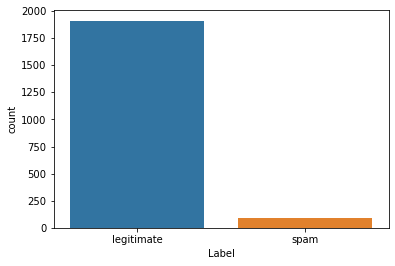

In [22]:
ax = sns.countplot(df.Label)
plt.xlabel('Label')